#**5.3.1 특성 추출 기법**

In [1]:
# 5-12 : 라이브러리 호출
import os
import time
import copy
import glob
import cv2 # OpenCV 라이브러리
import shutil

import torch
import torchvision # 컴퓨터 비전 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
from google.colab import files
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Saving catanddog.zip to catanddog.zip


In [3]:
!unzip catanddog.zip -d catanddog/    #catanddog 폴더 만들어 압축 풀기

Archive:  catanddog.zip
   creating: catanddog/test/
   creating: catanddog/test/Cat/
  inflating: catanddog/test/Cat/8100.jpg  
  inflating: catanddog/test/Cat/8101.jpg  
  inflating: catanddog/test/Cat/8102.jpg  
  inflating: catanddog/test/Cat/8103.jpg  
  inflating: catanddog/test/Cat/8104.jpg  
  inflating: catanddog/test/Cat/8105.jpg  
  inflating: catanddog/test/Cat/8106.jpg  
  inflating: catanddog/test/Cat/8107.jpg  
  inflating: catanddog/test/Cat/8108.jpg  
  inflating: catanddog/test/Cat/8109.jpg  
  inflating: catanddog/test/Cat/8110.jpg  
  inflating: catanddog/test/Cat/8111.jpg  
  inflating: catanddog/test/Cat/8112.jpg  
  inflating: catanddog/test/Cat/8113.jpg  
  inflating: catanddog/test/Cat/8114.jpg  
  inflating: catanddog/test/Cat/8115.jpg  
  inflating: catanddog/test/Cat/8116.jpg  
  inflating: catanddog/test/Cat/8117.jpg  
  inflating: catanddog/test/Cat/8118.jpg  
  inflating: catanddog/test/Cat/8119.jpg  
  inflating: catanddog/test/Cat/8120.jpg  
  inflating

In [4]:
# 5-13 : 이미지 데이터 전처리 방법 정의
data_path = 'catanddog/train/' # 이미지 데이터가 위치한 경로 저장

transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


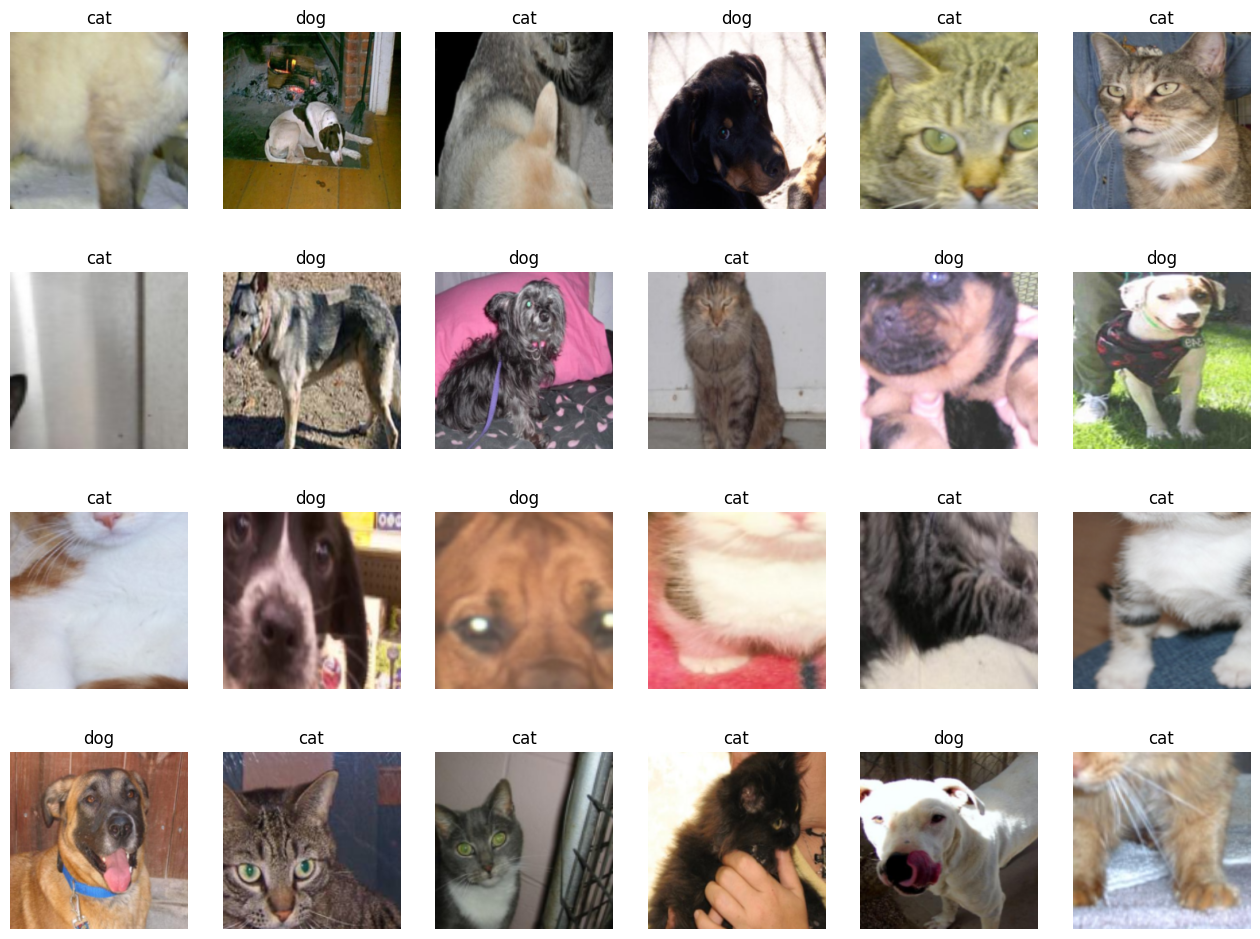

In [5]:
# 5-14 : 학습에 사용될 이미지 출력
import numpy as np

samples, labels = next(iter(train_loader)) # iter(train_loader).next()가 오류가 나서 next(iter)로 수정함
classes = {0:'cat', 1:'dog'} # 개와 고양이에 대한 클래스로 구성

fig = plt.figure(figsize=(16,24))
for i in range(24): # 24개의 이미지 데이터 출력
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()]) # 레이블 정보(클래스)를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
# 5-15 : 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True) # pretrained = True는 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [7]:
# 5-16 : 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [8]:
# 5-17 : ResNet18에 완전연결층 추가
resnet18.fc = nn.Linear(512, 2) # 2는 클래스가 두 개라는 의미

In [9]:
# 5-18 : 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters(): # model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0344,  0.0233, -0.0105,  ...,  0.0026, -0.0063, -0.0330],
        [-0.0430,  0.0168,  0.0424,  ...,  0.0039, -0.0016, -0.0405]])
fc.bias tensor([-0.0028,  0.0414])


In [10]:
# 5-19 : 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained = True) # 모델의 객체 생성

for param in model.parameters(): # 모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters(): # 완전연결층은 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() # 손실 함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# 5-20 : 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs): # 에포크(13)만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders: # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad() # 기울기를 0으로 설정
            outputs = model(inputs) # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data) # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장

        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch))) # 모델 재사용을 위해 저장
        print()

    time_elapsed = time.time() - since # 실행 시간(학습 시간)을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history # 모델의 정확도와 오차를 반환

In [12]:
# 5-21 : 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param) # 파라미터 학습 결과를 저장
        print("\t",name)

optimizer = optim.Adam(params_to_update) # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


In [13]:
# 5-22 : 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5408 Acc: 0.7039

Epoch 1/12
----------
Loss: 0.4074 Acc: 0.7948

Epoch 2/12
----------
Loss: 0.3384 Acc: 0.8701

Epoch 3/12
----------
Loss: 0.3117 Acc: 0.8545

Epoch 4/12
----------
Loss: 0.2350 Acc: 0.9195

Epoch 5/12
----------
Loss: 0.2206 Acc: 0.9325

Epoch 6/12
----------
Loss: 0.2430 Acc: 0.9013

Epoch 7/12
----------
Loss: 0.2063 Acc: 0.9143

Epoch 8/12
----------
Loss: 0.2266 Acc: 0.9039

Epoch 9/12
----------
Loss: 0.2018 Acc: 0.9247

Epoch 10/12
----------
Loss: 0.1979 Acc: 0.9221

Epoch 11/12
----------
Loss: 0.2068 Acc: 0.9195

Epoch 12/12
----------
Loss: 0.1971 Acc: 0.9195

Training complete in 0m 36s
Best Acc: 0.932468


In [14]:
# 5-23 : 테스트 데이터 호출 및 전처리
test_path = 'catanddog/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [15]:
# 5-24 : 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort() # 불러온 .pth 파일들을 정렬
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders: # 테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad(): # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs) # 데이터를 모델에 적용한 결과를 outputs에 저장

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1 # torch.max로 출력한 값이 0.5보다 크면 올바르게 예측
            preds[preds < 0.5] = 0 # 작으면 틀리게 예측
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 테스트 데이터의 정확도 계산
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history # 계산된 정확도 반환

In [16]:
# 5-25 : 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth


<ipython-input-15-8dc75ebb4ea6>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Acc: 0.9184

Loading model catanddog/01.pth
Acc: 0.9388

Loading model catanddog/02.pth
Acc: 0.9184

Loading model catanddog/03.pth
Acc: 0.9592

Loading model catanddog/04.pth
Acc: 0.9592

Loading model catanddog/05.pth
Acc: 0.9592

Loading model catanddog/06.pth
Acc: 0.9286

Loading model catanddog/07.pth
Acc: 0.9592

Loading model catanddog/08.pth
Acc: 0.9592

Loading model catanddog/09.pth
Acc: 0.9592

Loading model catanddog/10.pth
Acc: 0.9592

Loading model catanddog/11.pth
Acc: 0.9796

Loading model catanddog/12.pth
Acc: 0.9592

Validation complete in 0m 8s
Best Acc: 0.979592


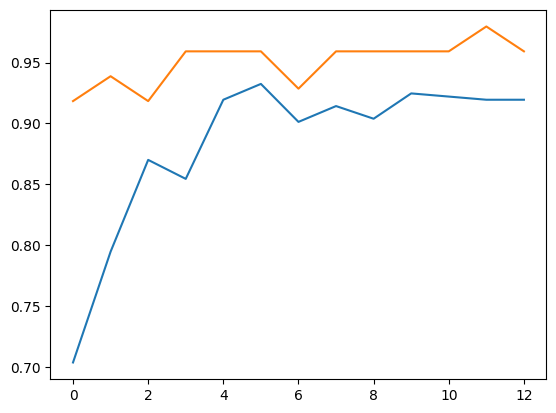

In [17]:
# 5-26 : 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

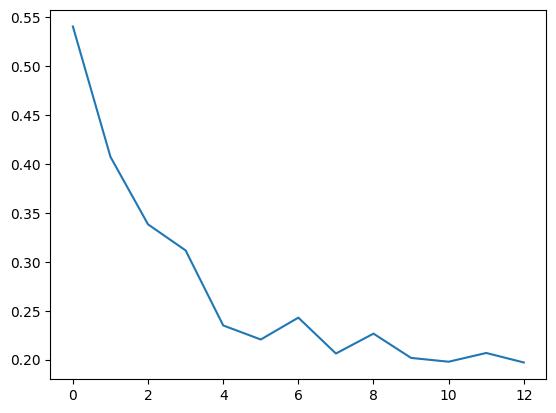

In [18]:
# 5-27 : 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

In [19]:
# 5-28 : 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

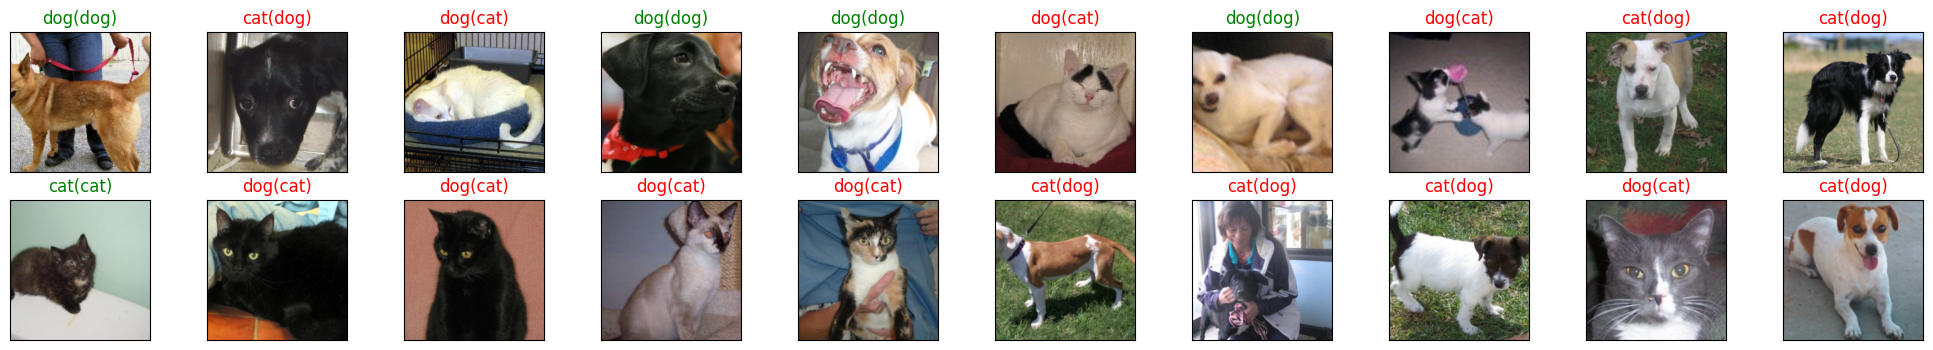

<Figure size 640x480 with 0 Axes>

In [20]:
# 5-29 : 개와 고양이 예측 결과 출력
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader) # 테스트 데이터셋을 가져옴
images,labels=next(dataiter) # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져옴
                             # +) dataiter.next()가 오류 나서 next(dataiter)로 수정함
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx])) # 이미지 출력을 위해 코드 5-28에서 정의한 im_convert 함수를 적용
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

# **5.4.1 특성 맵 시각화**

In [21]:
# 5-30 : 필요한 라이브러리 호출
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
# 5-31 : 설명 가능한 네트워크 생성
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), # inplace=True는 기존의 데이터를 연산의 결괏값으로 대체하는 것을 의미
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [23]:
# 5-32 : 모델 객체화
model=XAI() # model이라는 이름의 객체를 생성
model.cpu() # model을 장치(CPU 혹은 GPU)에 할당 : 모델에 입력되는 이미지를 넘파이로 받아오는 부분때문에 CPU를 사용하도록 지정하였습니다
model.eval() # 테스트 데이터에 대한 모델 평가 용도로 사용

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [24]:
# 5-33 : 특성 맵을 확인하기 위한 클래스 정의
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # output = output
        # self.features = output.to(device).detach().numpy()
        # TypeError: can't convert cuda:0 device type tensor to numpy.
        #            Use Tensor.cpu() to copy the tensor to host memory first.
        self.features = output.detach().cpu().numpy()

    def remove(self): # hook 삭제
        self.hook.remove()

Saving cat.jpg to cat.jpg
torch.Size([1, 3, 100, 100])


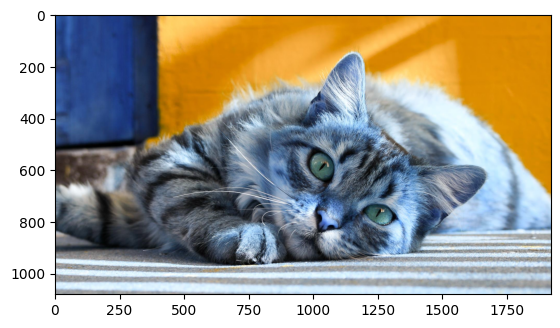

In [25]:
# 5-34 : 이미지 호출
from google.colab import files
file_uploaded=files.upload()   # chap05/data/cat.jpg 데이터 불러오기

img=cv2.imread("cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)

print(img.shape)

In [26]:
# 5-35 : (0): Conv2d 특성 맵 확인
result = LayerActivations(model.features, 0) # 0번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

<ipython-input-22-68d2cc761ba1>:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


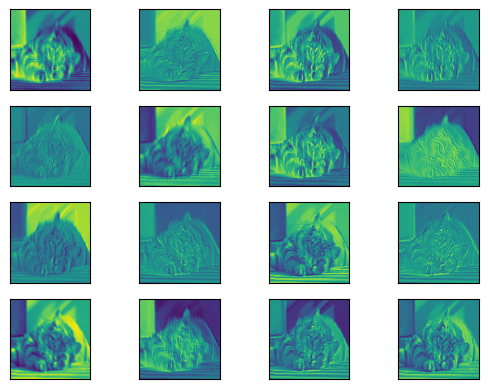

<Figure size 1200x800 with 0 Axes>

In [27]:
# 5-36 : 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [28]:
# 5-37 : 20번째 계층에 대한 특성 맵
result = LayerActivations(model.features, 20) # 20번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

<ipython-input-22-68d2cc761ba1>:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


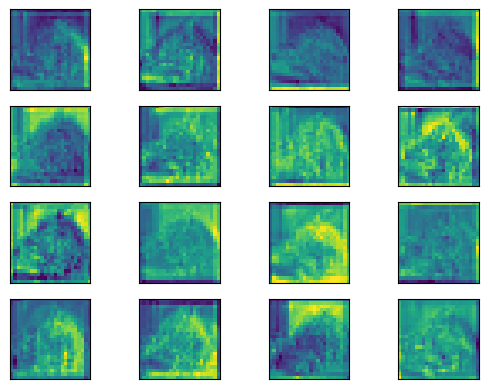

<Figure size 1200x800 with 0 Axes>

In [29]:
# 5-38 : 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [30]:
# 5-39 : 40번째 계층에 대한 특성 맵
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

<ipython-input-22-68d2cc761ba1>:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


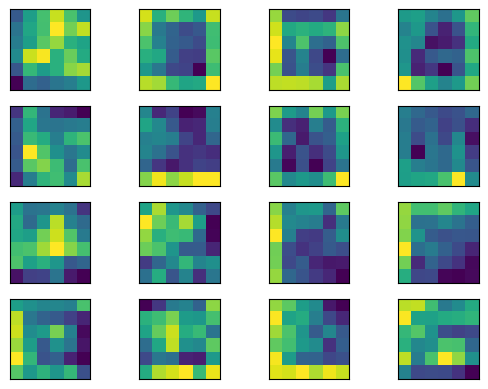

<Figure size 1200x800 with 0 Axes>

In [31]:
# 5-40 : 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()